**Transfer learning**

In [16]:
#matplotlib 환경설정
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

#필요 라이브러리 import
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [17]:
# # M1 맥북에서 돌려보기 위해서 그냥 내가 한거..,, 시험하고는 관련 없다. 
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
# print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
# print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
# !python -c 'import platform;print(platform.platform())'

PyTorch version:1.13.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-13.0.1-arm64-arm-64bit


**Dataset load**

In [18]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

#zip 파일 현재 폴더로 복사, 중간 부분은 파일명에 따라 변경 필요 
!cp /content/drive/MyDrive/ants_bees.zip ./

In [19]:
#압축 해제
!unzip ants_bees.zip

In [29]:
# 데이터 증강 및 정규화
# 이미지 데이터셋을 불러오기 전에 데이터 증강 및 정규화에 대한 선언을 먼저 진행
# torchvision.transforms에는 이미지 및 텐서에 적용 가능한 다양한 변환이 있음
# 데이터 증강은 학습 데이터셋에만 적용함!!!!!!!!!!!!!!!!!!!!!!!!!!!!
########################################################################
data_trasforms = {
    'train':transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), # 수평 반전
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 평균과 분산
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 평균과 분산
    ]),
}
########################################################################

# ImageFolder 기능을 활용한 PyTorch 데이터셋 및 데이터로더 생성
# torchvision.datasets의 ImageFolder 클래스는 이미지 폴더를 읽어들여 PyTorch dataset으로 변환 (folder_path, transforms 두 종류의 argument를 입력하여 활용 가능)
# dataset 생성 후 미니배치 학습을 위한 데이터로더 또한 생성함
########################################################################
data_dir = 'ants_bees'
image_datasets ={ x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_trasforms[x])
                 for x in ['train', 'val']}
########################################################################

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

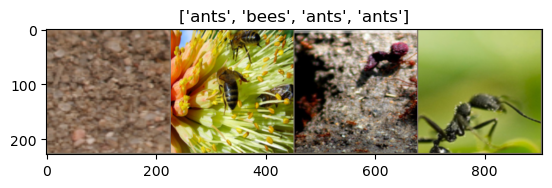

In [21]:
# 데이터셋 랜덤 샘플링 및 시각화 -> 꼭 필요하지 않으나 데이터셋 안에 어떤 이미지들이 있는지 확인하기 위해 미니배치 데이터를 받아와서 시각화 진행
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Function for training**

In [22]:
# 구현은 완료되어 있으나 코드 한번 살펴보길 권장
# 학습 및 매 epoch마다 검증까지 같이 수행하는 형태
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다. 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 미니 배치 학습 루프
            for inputs, labels in dataloaders[phase]: # phase = val
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # 순전파 forward
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())  # best_model 가중치 저장

        print()

    # 정해진 epoch만큼 학습을 수행한 후 검증 데이터셋에서의 성능이 가장 좋은 가중치로 모델을 복구시킨 후 반환
    # 이후 테스트, inference로의 활용 등을 고려한 함수 형태
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

**전이 학습 실습 및 구현**

**torchvision.models에서는 이미지 분류를 위한 다양한 모델 제공**
**각 모델마다 세부 함수는 다르지만, 이미지넷에서 미리 학습된 가중치를 불러오고 싶다면 pretrained = True로 생성자 함수를 호출하면 된다**
**클래스 개수를 num_classes라는 이름의 매개변수로 지정할 수 있다.**

**Resnet training from scratch**

In [33]:
# ResNet 가중치 초기화 후 학습
# ResNet18 모델로 가중치 초기화 후 학습을 진행
########################################################################
model_ft = models.resnet18(pretrained=False, num_classes=2)
model_ft = model_ft.to(device)
########################################################################
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

/Users/gimseong-eon/opt/anaconda3/envs/GPU_base/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gimseong-eon/opt/anaconda3/envs/GPU_base/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/9
----------


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

**Resnet training with transfer learning**

In [34]:
# ResNet 전이 학습 
# 가중치를 불러올 때는 이미지넷에서 학습된 버전이므로 클래스 개수가 1000개로 고정 -> 이를 2개로 변경해야한다~
# 클래스 개수가 1000개가 아닌 데이터셋에 대한 전이 학습 시에는 모델 생성 이후 마지막 전결합층을 다시 선언해주어야 하는데, 이 때 상세한 코드는 신경망 구조에 따라 달라짐
# 공식 코드를 확인해보면 ResNet는 fc라는 이름의 마지막 전결합층을 갖고 있다.
########################################################################
model_ft = models.resnet18(pretrained=True) # 받아올 땐 class 1000개, 여기에 num_lasses=2 해주면 오류가 발생한다.
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
########################################################################

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

/Users/gimseong-eon/opt/anaconda3/envs/GPU_base/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gimseong-eon/opt/anaconda3/envs/GPU_base/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/gimseong-eon/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/9
----------


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

**EfficientNetV2 training from scratch**

In [ ]:
#EfficientNetV2 가중치 초기화 후 학습
#ResNet보다 성능이 떨어진다.
########################################################################
model_ft = models.efficientnet_v2_s(pretrained=False, num_classes=2)
model_ft = model_ft.to(device)
########################################################################

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

**EfficientNetV2 training with transfer learning**

In [ ]:
#EfficientNetV2 전이학습
#공식코드를 확인해보면 EfficientNetV2는 classifier라는 이름의 마지막 전결합층을 갖고 있다
#Dropout은 제외하고 새로운 전결합층 생성 예정
########################################################################
model_ft = models.efficientnet_v2_s(pretrained=True) # 받아올 땐 class 1000개
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
########################################################################

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)